<a href="https://colab.research.google.com/github/valterlucena/facial-expression-detector/blob/master/facial_expressions_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# @title Dependências

import numpy as np 
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split as tts
from google.colab.patches import cv2_imshow
from sklearn.model_selection import train_test_split
from keras.layers import Activation, Convolution2D, Dropout, Conv2D
from keras.layers import AveragePooling2D, BatchNormalization
from keras.layers import GlobalAveragePooling2D
from keras.models import Sequential
from keras.layers import Flatten
from keras.models import Model
from keras.layers import Input
from keras.layers import MaxPooling2D
from keras.layers import SeparableConv2D
from keras import layers
from keras.regularizers import l2
import pandas as pd
import cv2
import numpy as np
from sklearn.utils import shuffle
import os, cv2

Para realizar o experimento, utilizaremos Python com o auxílio do keras, pandas e outras bibliotecas que nos auxiliará a manipular as imagens.

Inicialmente, importaremos a base de imagens contendo rostos de diversas pessoas demonstrando emoções diferentes. Para cada pessoa, teremos duas imagens
de cada emoção sendo elas: **felicidade, nojo, raiva, tristeza, medo e uma expressão neutra**. A base contém 72 fotos.

In [60]:
from google.colab import drive
drive.mount('/content/gdrive')
width = int(2835)
heigth = int(3543)

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


Cada imagem tem uma dimensão de 3543 x 2835 e passará por um pré processamento antes de ser inputada no modelo de treinamento. Os trataremos que faremos serão os seguinte:


*   Detecção de *bounding box* para face (com intuito de eliminar background)
*   Redução de RGB para escala de cinza (com intuito de reduzir o espaço gasto e assim otimizar o treinamento)
*   Redução das dimensões das imagens (com intuito de reduzir o espaço gasto e assim otimizar o treinamento).



In [0]:
import cv2
import dlib

# Carrega Rede neural convolucional para detecção de face
dnnFaceDetector=dlib.cnn_face_detection_model_v1("mmod_human_face_detector.dat")

path = '/content/gdrive/My Drive/PercepcaoComputacional/faces/'
imgfiles = [ifile for ifile in os.listdir(path) if ifile.endswith('.jpg')]
images = []
# As labels de cada emoção estão definidas no nome do arquivo
labels = [label[-7][0] for label in imgfiles]
for imgfile in imgfiles:
    img = cv2.imread(path + imgfile)
    # Aqui realizamos a mudança para a escala de cinza
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # Reconhecemos a face
    rects=dnnFaceDetector(gray,1)
   
    left,top,right,bottom=0,0,0,0
    for (i,rect) in enumerate(rects):
      left=rect.rect.left() #x1
      top=rect.rect.top() #y1
      right=rect.rect.right() #x2
      bottom=rect.rect.bottom() #y2
      width=right-left
      height=bottom-top

      # Realizamos a cropagem da imagem 
      img_crop=gray[top:top+height,left:left+width]
      # Reduzimos sua dimensão para um valor predefinido
      img = cv2.resize(img_crop,(200, 200), interpolation = cv2.INTER_AREA)
      images.append(img)

A seguir temos uma imagem resultado de como ficou nossa base pós processamento:

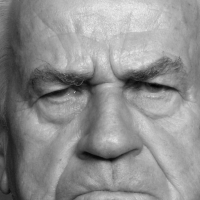

In [89]:
cv2_imshow(images[0])

In [0]:
unique_labels = list(set(labels))
wi = {v: i for i, v in enumerate(unique_labels)}
rwi = {i: v for i, v in enumerate(unique_labels)}
num_labels = [wi[l] for l in labels]

In [0]:
imagesnp = np.array(images)
imagesnp = imagesnp.reshape(-1, 200, 200,1)

In [0]:
regularization = l2(0.01)
img_input = Input((200, 200, 1))
x = Conv2D(8, (3, 3), strides=(1, 1), kernel_regularizer=regularization, use_bias=False)(img_input)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Conv2D(8, (3, 3), strides=(1, 1), kernel_regularizer=regularization, use_bias=False)(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
 
# module 1
residual = Conv2D(16, (1, 1), strides=(2, 2), padding='same', use_bias=False)(x)
residual = BatchNormalization()(residual)
x = SeparableConv2D(16, (3, 3), padding='same', kernel_regularizer=regularization, use_bias=False)(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = SeparableConv2D(16, (3, 3), padding='same', kernel_regularizer=regularization, use_bias=False)(x)
x = BatchNormalization()(x)
x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)
x = layers.add([x, residual])
 
# module 2
residual = Conv2D(32, (1, 1), strides=(2, 2), padding='same', use_bias=False)(x)
residual = BatchNormalization()(residual)
x = SeparableConv2D(32, (3, 3), padding='same', kernel_regularizer=regularization, use_bias=False)(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = SeparableConv2D(32, (3, 3), padding='same', kernel_regularizer=regularization, use_bias=False)(x)
x = BatchNormalization()(x)
x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)
x = layers.add([x, residual])
 
# module 3
residual = Conv2D(64, (1, 1), strides=(2, 2),padding='same', use_bias=False)(x)
residual = BatchNormalization()(residual)
x = SeparableConv2D(64, (3, 3), padding='same',kernel_regularizer=regularization,use_bias=False)(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = SeparableConv2D(64, (3, 3), padding='same',kernel_regularizer=regularization,use_bias=False)(x)
x = BatchNormalization()(x)
x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)
x = layers.add([x, residual])
 
# module 4
residual = Conv2D(128, (1, 1), strides=(2, 2),padding='same', use_bias=False)(x)
residual = BatchNormalization()(residual)
x = SeparableConv2D(128, (3, 3), padding='same',kernel_regularizer=regularization,use_bias=False)(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = SeparableConv2D(128, (3, 3), padding='same',kernel_regularizer=regularization,use_bias=False)(x)
x = BatchNormalization()(x)
x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)
x = layers.add([x, residual])
x = Conv2D(len(unique_labels), (3, 3), padding='same')(x)
x = GlobalAveragePooling2D()(x)
output = Activation('softmax',name='predictions')(x)
 
model = Model(img_input, output)
model.compile(optimizer='adam', loss='categorical_crossentropy',metrics=['accuracy'])
model.summary()

In [0]:
cat_labels = keras.utils.to_categorical(num_labels)
x, y = shuffle(imagesnp, cat_labels, random_state=42)
x_train, x_test, y_train, y_test = tts(x, y, test_size=0.2)

In [0]:
EPOCHS = 100
validation_data = (x_test, y_test)

In [98]:
model.fit(x_train, y_train, validation_data=validation_data, epochs=EPOCHS)

Train on 57 samples, validate on 15 samples
Epoch 1/100
57/57 [==============================] - 2s 36ms/step - loss: 0.7820 - acc: 0.7719 - val_loss: 1.1690 - val_acc: 0.5333
Epoch 2/100
57/57 [==============================] - 1s 16ms/step - loss: 0.5002 - acc: 0.8421 - val_loss: 9.4784 - val_acc: 0.1333
Epoch 3/100
57/57 [==============================] - 1s 16ms/step - loss: 0.3847 - acc: 0.8947 - val_loss: 14.8472 - val_acc: 0.0000e+00
Epoch 4/100
57/57 [==============================] - 1s 16ms/step - loss: 0.2828 - acc: 0.9649 - val_loss: 15.7694 - val_acc: 0.0000e+00
Epoch 5/100
57/57 [==============================] - 1s 16ms/step - loss: 0.2413 - acc: 0.9825 - val_loss: 15.4861 - val_acc: 0.0000e+00
Epoch 6/100
57/57 [==============================] - 1s 16ms/step - loss: 0.2066 - acc: 1.0000 - val_loss: 14.6180 - val_acc: 0.0000e+00
Epoch 7/100
57/57 [==============================] - 1s 16ms/step - loss: 0.1570 - acc: 1.0000 - val_loss: 11.6660 - val_acc: 0.0000e+00
Epoch 8